# Experiment 1. VAR network identification on Dynamic Causal Models (DCMs) network data

Set variable **`flag_wrt_data`** to True to generate new data.
<div class="alert alert-block alert-danger">
<b>Warning:</b> Existing data in the directory <span style="color:red"><strong>data_dirname</strong></span> will be removed.
</div>

In [2]:
!pip install -U mne-connectivity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.2/115.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.1 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
sys.path.insert(0, "/content/drive/MyDrive/Balloon/scripts")

from dcm_exp1 import write_dcm_dataset_exp1, get_random_A, get_dcm_instance

In [5]:
#%reload_ext autoreload
#%autoreload 2

flag_wrt_data = True   # Change this if you want to create new data.

import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import sys
#sys.path.append('scripts')
sys.path.append('/content/drive/MyDrive/Balloon/scripts')
#sys.path.append('')
print(sys.path)
from dcm_exp1 import write_dcm_dataset_exp1
from utils import load_nii, save_nii, \
                    signal_2_var, force_lower_triangular, var_parameters_2_A, \
                    get_dcm_node_signals, plot_dcm

data_dirname = 'data_dcm'
figs_dirname = 'figs'
if not os.path.exists(figs_dirname): os.mkdir(figs_dirname)

['/content/drive/MyDrive/Balloon/scripts', '/content', '/env/python', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.12/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/Balloon/scripts']


In [6]:
!ls /content/drive/MyDrive/Balloon/scripts

algorithms_var.py  hrf_spm.py	      __pycache__      utils.py
dcm_exp1.py	   noise_nodrift.mat  utils_deconv.py


## Dataset generation

In [7]:
# N_pts is the number of time points of each signal sampled every TR seconds
# N_nds is the number of brain regions = number of DCM nodes
# N_signals is the number of signals belonging to each brain region (assumed to be equal for each brain node, this is not true for real data)

if flag_wrt_data:
    if os.path.exists(data_dirname): shutil.rmtree(data_dirname)
    N_pts = 3000
    TR = 2
    N_signals = 2
    N_subjects = 1
    SNRs = [0, 0.5]
    Conns = [10, 20, 30]
    Nnds = [10]

    timeline = TR * np.arange(0, N_pts)
    for nds in Nnds:
        for conn in Conns:
            N_nds = nds
            N_conn = conn
            write_dcm_dataset_exp1(     timeline,
                                        N_subjects=N_subjects,
                                        N_nds=N_nds,
                                        N_conn=N_conn,
                                        N_instances=N_signals,
                                        nblocks=5,
                                        duration_range=(1,3),
                                        SNRs=SNRs,
                                        data_dirname=data_dirname
                                    )

[[-1.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. ]
 [ 0.8 -1.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. ]
 [-0.  -0.  -1.  -0.  -0.  -0.  -0.  -0.  -0.  -0. ]
 [-0.  -0.   0.6 -1.  -0.  -0.  -0.  -0.  -0.  -0. ]
 [-0.  -0.  -0.  -0.  -1.  -0.  -0.  -0.  -0.  -0. ]
 [-0.  -0.  -0.   0.6 -0.  -1.  -0.  -0.  -0.  -0. ]
 [-0.   0.6 -0.  -0.   0.6 -0.  -1.  -0.  -0.  -0. ]
 [ 0.7 -0.  -0.  -0.  -0.  -0.  -0.  -1.  -0.  -0. ]
 [-0.  -0.  -0.  -0.   0.6 -0.  -0.  -0.  -1.  -0. ]
 [-0.  -0.  -0.  -0.   0.7 -0.  -0.   0.8  0.5 -1. ]]
Saving the file data_dcm/nds10_conn10/sub1/A.nii
Saving the file data_dcm/nds10_conn10/sub1/U.nii
Saving the file data_dcm/nds10_conn10/sub1/X_snr0.nii
Saving the file data_dcm/nds10_conn10/sub1/X_snr0.5.nii
[[-1.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. ]
 [ 0.5 -1.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. ]
 [-0.   0.5 -1.  -0.  -0.  -0.  -0.  -0.  -0.  -0. ]
 [-0.  -0.  -0.  -1.  -0.  -0.  -0.  -0.  -0.  -0. ]
 [-0.  -0.  -0.   0.5 -1.  -0.  -0.  -0.  -0.  -0

## Visualization and manipulation of one DCM instance (subject 1)

Directed adjacency matrix
[[0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.8 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.6 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.6 0.  0.  0.  0.  0.  0. ]
 [0.  0.6 0.  0.  0.6 0.  0.  0.  0.  0. ]
 [0.7 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.6 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.7 0.  0.  0.8 0.5 0. ]]
Time points: 3000
Number of DCM nodes (brain regions): 10
Number of signals per region: 2
Number of connections: 10
Shape of X: (3000, 10, 2)
Shape of A: (10, 10)
Shape of U: (3000, 10)


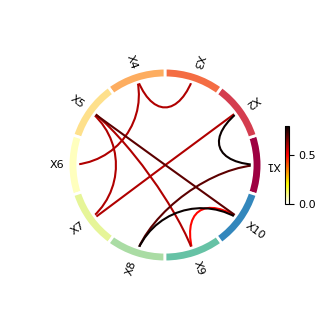

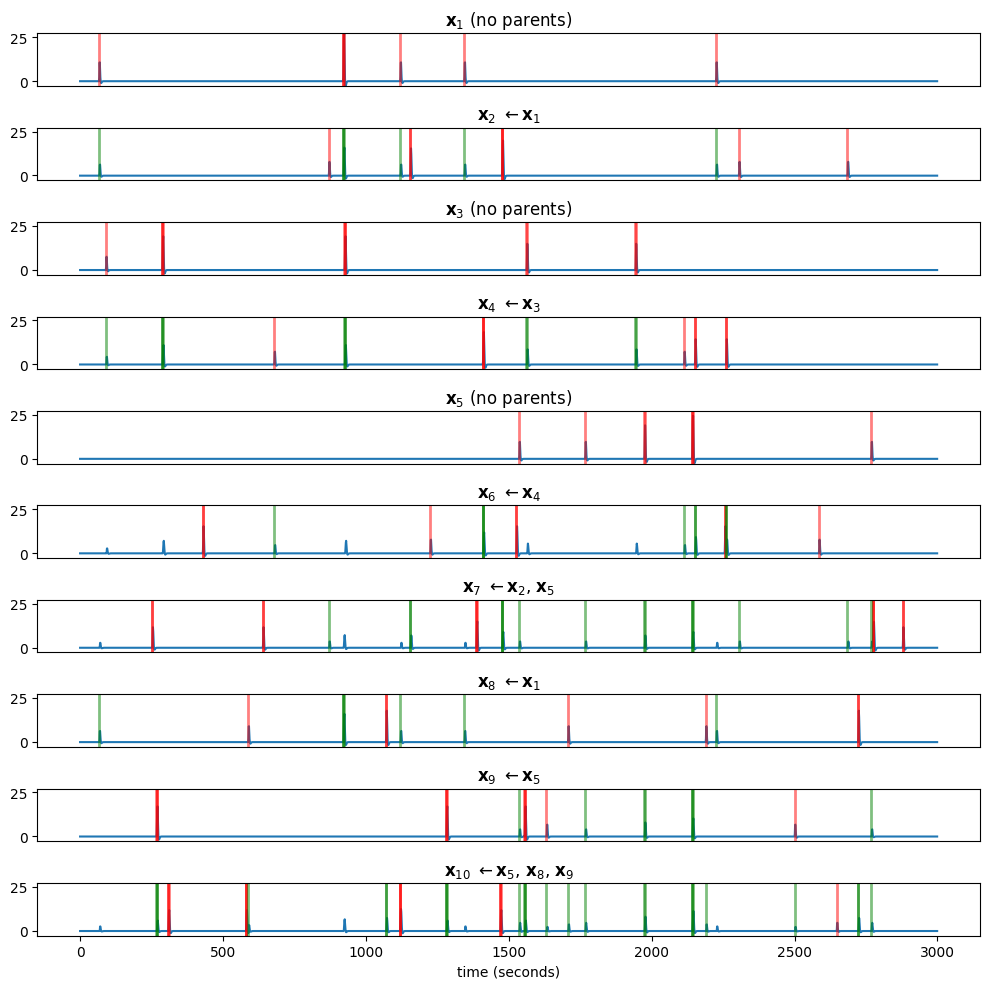

In [8]:
datadir = os.path.join('data_dcm', 'nds10_conn10', 'sub1')
A = load_nii(os.path.join(datadir, 'A.nii')) # True network connections
Altri = force_lower_triangular(A) # A as lower triangular matrix
U = load_nii(os.path.join(datadir, 'U.nii')) # pseudoevents used to generate BOLD fluctuations
X = load_nii(os.path.join(datadir, 'X_snr0.nii')) # BOLD fluctuations


# N_pts is the number of time points of each signal sampled every TR seconds
# N_nds is the number of brain regions = number of DCM nodes
# N_signals is the number of signals belonging to each brain region (assumed to be equal for each brain node, this is not true for real data)
N_pts, N_nds, N_signals = X.shape
N_conn = np.sum( Altri!=0 ) # number of connections (number of A matrix entries greater than zero)
TR = 1
timeline = TR * np.arange(0, N_pts)

print('Directed adjacency matrix')
print(Altri)
print(f'Time points: {N_pts}\nNumber of DCM nodes (brain regions): {N_nds}\nNumber of signals per region: {N_signals}\nNumber of connections: {N_conn}')
print(f'Shape of X: {X.shape}\nShape of A: {A.shape}\nShape of U: {U.shape}')

plot_dcm(X, A, U, timeline, dcm_index=0, show_connections=True)

## DCM signals average

In [9]:
print(plot_dcm.__module__)
print(plot_dcm.__code__.co_filename)

utils
/content/drive/MyDrive/Balloon/scripts/utils.py


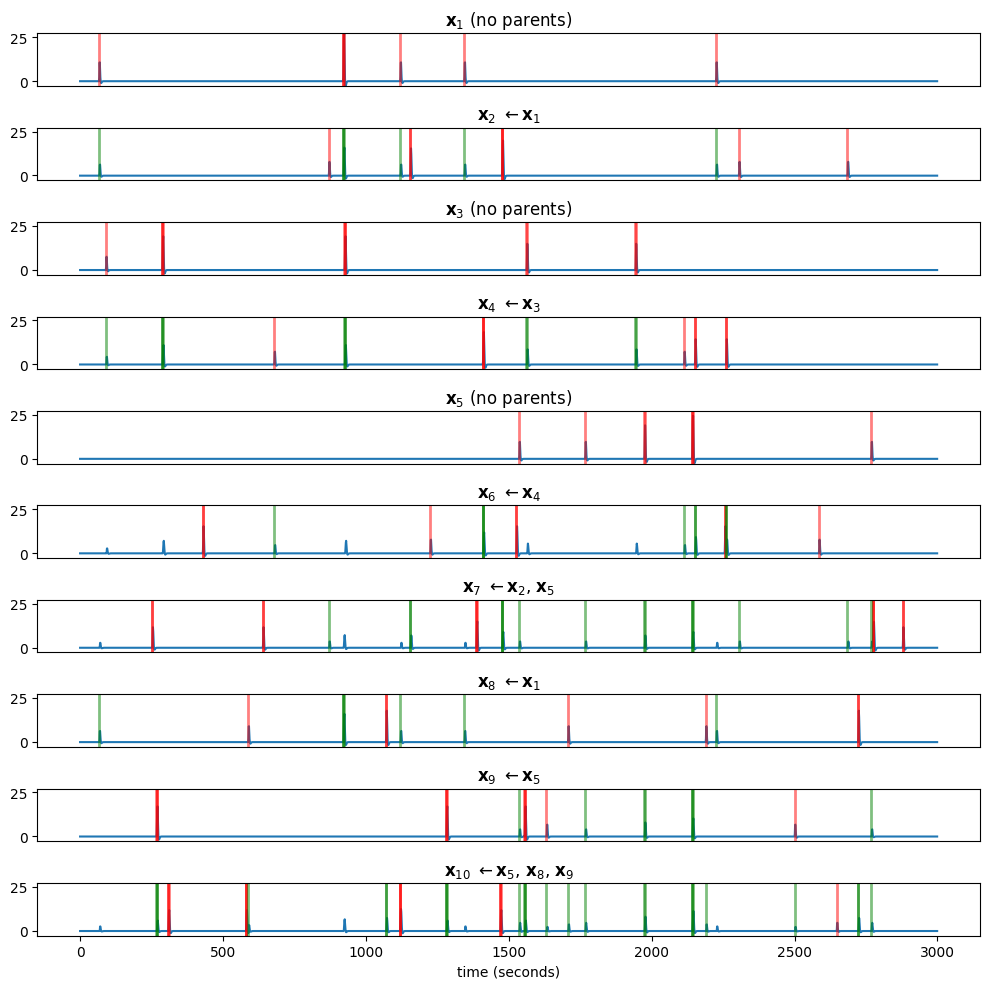

In [10]:
import os # Ensure os is imported

Xav = X.mean(axis=2)

# Create the missing directory if it doesn't exist
output_dir = '/content/drive/MyDrive/Balloon/figs'
if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)

plot_dcm(Xav, A, U, timeline)

Forma de A_true: (10, 10)
Ejemplo de valores:
 [[-1.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. ]
 [ 0.8 -1.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. ]
 [-0.  -0.  -1.  -0.  -0.  -0.  -0.  -0.  -0.  -0. ]
 [-0.  -0.   0.6 -1.  -0.  -0.  -0.  -0.  -0.  -0. ]
 [-0.  -0.  -0.  -0.  -1.  -0.  -0.  -0.  -0.  -0. ]
 [-0.  -0.  -0.   0.6 -0.  -1.  -0.  -0.  -0.  -0. ]
 [-0.   0.6 -0.  -0.   0.6 -0.  -1.  -0.  -0.  -0. ]
 [ 0.7 -0.  -0.  -0.  -0.  -0.  -0.  -1.  -0.  -0. ]
 [-0.  -0.  -0.  -0.   0.6 -0.  -0.  -0.  -1.  -0. ]
 [-0.  -0.  -0.  -0.   0.7 -0.  -0.   0.8  0.5 -1. ]]


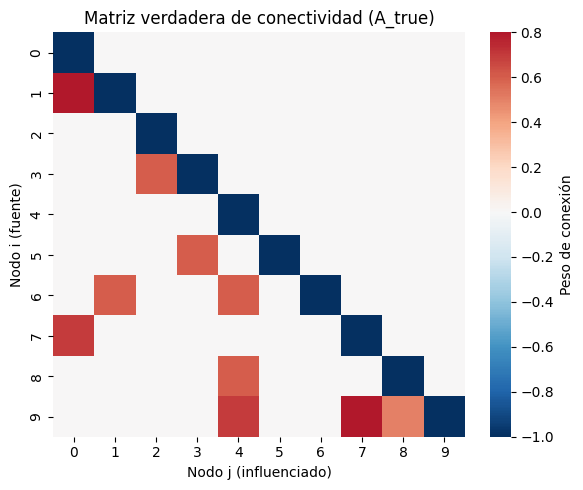

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import seaborn as sns

# Ruta hacia el archivo (ajústala si tu carpeta difiere)
base_path = "data_dcm"
#subject_id = "sub1" # Corrected subject directory name
#A_path = os.path.join(base_path, subject_id, "A.nii")

# Construct the path including nds and conn subdirectories
data_subdir = f"nds{N_nds}_conn{N_conn}"
subject_id = "sub1"
A_path = os.path.join(base_path, data_subdir, subject_id, "A.nii")


# Cargar la matriz A (ground truth)
A_img = nib.load(A_path)
A_true = A_img.get_fdata().squeeze()  # elimina dimensiones extra

print("Forma de A_true:", A_true.shape)
print("Ejemplo de valores:\n", A_true)

# --- Visualización de los pesos ---
plt.figure(figsize=(6, 5))
sns.heatmap(A_true, cmap="RdBu_r", center=0, annot=False,
            cbar_kws={'label': 'Peso de conexión'})
plt.title("Matriz verdadera de conectividad (A_true)")
plt.xlabel("Nodo j (influenciado)")
plt.ylabel("Nodo i (fuente)")
plt.tight_layout()
plt.show()

In [12]:
pip install lingam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.4/134.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.3/94.3 kB 5.1 MB/s eta 0:00:00
  Created wheel for semopy: filename=semopy-2.3.11-py3-none-any.whl size=1659682 sha256=b15ccb01c328727b5951edd417f4c2883bda32ccfe616b581348a4e38464906d
  Stored in directory: /root/.cache/pip/wheels/c6/24/8b/be911b059a61f490f38425eb19bf2fed470a5ead97228e8255
Successfully built semopy


# VAR-LiNGAM con DCM

## Intento 3A

Shapes -> A_true: (10, 10) | X: (3000, 10)
B0 shape: (10, 10)
Number of estimated lags: 1
Saved to: /content/data_dcm/nds10_conn10/sub1
MSE(B0 vs A_true) = 0.020718 | Corr = 0.917
MSE(Beff vs A_true) = 0.025311 | Corr = 0.837


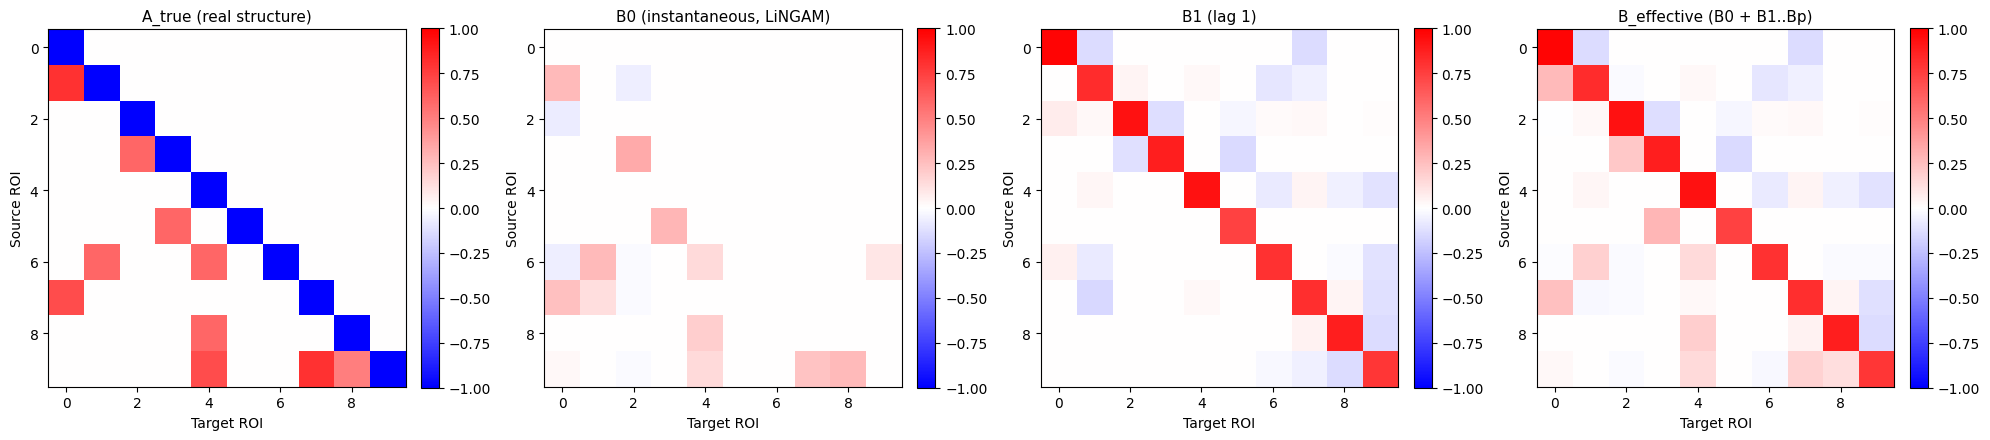

In [13]:
# ==========================================
# VAR-LiNGAM factual on DCM data
# ==========================================

import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from lingam import VARLiNGAM

# ------- Config --------
base_dir = "/content/data_dcm"
nds = 10
conn = 10
sub = "sub1"
snr_tag = "0"  # use "0" or "0.5"

datadir = os.path.join(base_dir, f"nds{nds}_conn{conn}", sub)

# ------- Load ground truth A and BOLD X --------
A_path = os.path.join(datadir, "A.nii")
X_path = os.path.join(datadir, f"X_snr{snr_tag}.nii")

A_true = np.asanyarray(nib.load(A_path).get_fdata()).squeeze()   # (D, D)
X_full = np.asanyarray(nib.load(X_path).get_fdata())             # (T, D, N_signals)

# Average instances -> (T, D)
X = X_full.mean(axis=2)
print("Shapes -> A_true:", A_true.shape, "| X:", X.shape)

# ------- (optional) Standardize by ROI --------
Xz = StandardScaler(with_mean=True, with_std=True).fit_transform(X)

# ------- VAR-LiNGAM fitting --------
# Option A (fixed order):
model = VARLiNGAM(lags=1, criterion=None, prune=True, random_state=50)

# # Option B (automatic order selection):
# model = VARLiNGAM(criterion='bic', prune=True, random_state=42)

model.fit(Xz)
B_list = model.adjacency_matrices_  # [B0, B1, ..., Bp]
print("B0 shape:", B_list[0].shape)
print("Number of estimated lags:", len(B_list)-1)

# Effective matrix = sum of all lags (includes B0)
B_effective = np.sum(B_list, axis=0)

# ------- Save results --------
np.save(os.path.join(datadir, "B0_factual.npy"), B_list[0])
np.save(os.path.join(datadir, "B_effective_factual.npy"), B_effective)
print("Saved to:", datadir)

# ------- Quick metrics (off-diagonal) --------
def vec_offdiag(M):
    d = M.shape[0]
    mask = ~np.eye(d, dtype=bool)
    return M[mask].ravel()

y_true = vec_offdiag(A_true)
y_b0   = vec_offdiag(B_list[0])
y_be   = vec_offdiag(B_effective)

def safe_corr(a, b):
    if np.std(a)==0 or np.std(b)==0: return np.nan
    return np.corrcoef(a, b)[0, 1]

mse_b0  = np.mean((y_true - y_b0)**2)
mse_be  = np.mean((y_true - y_be)**2)
corr_b0 = safe_corr(y_true, y_b0)
corr_be = safe_corr(y_true, y_be)

print(f"MSE(B0 vs A_true) = {mse_b0:.6f} | Corr = {corr_b0:.3f}")
print(f"MSE(Beff vs A_true) = {mse_be:.6f} | Corr = {corr_be:.3f}")

# ------------------------------------------------------------
# 5) Visualization: ALL lags + A_true + B_effective
# ------------------------------------------------------------
mats_to_plot = []
mats_to_plot.append(("A_true (real structure)", A_true))       # ground truth
mats_to_plot.append(("B0 (instantaneous, LiNGAM)", B_list[0]))    # B0

# VAR lags (delays)
for i in range(1, len(B_list)):
    mats_to_plot.append((f"B{i} (lag {i})", B_list[i]))

# Summary of lagged effects
mats_to_plot.append(("B_effective (B0 + B1..Bp)", B_effective))

# Visualization in one row
n_mats = len(mats_to_plot)
fig, axes = plt.subplots(1, n_mats, figsize=(5 * n_mats, 5))
if n_mats == 1:
    axes = [axes]

# Global color scale
v = max(np.max(np.abs(M)) for _, M in mats_to_plot)
v = 1.0 if v == 0 else v

for ax, (title, M) in zip(axes, mats_to_plot):
    im = ax.imshow(M, cmap="bwr", vmin=-v, vmax=v)
    ax.set_title(title, fontsize=11)
    ax.set_xlabel("Target ROI")
    ax.set_ylabel("Source ROI")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Ground truth, DCM, VARLiNGAM


## Intento 3B

In [14]:
import numpy as np, random
np.random.seed(42)
random.seed(42)

def create_asym_matrix(D: int, scale: float = 1, sparsity: float = 0.3, seed: int = None, gain: float = 1.2):
    """
    Genera una matriz de conectividad asimétrica, esparsa,
    y le potencia las conexiones sin alterar estructura ni signos
    y manteniéndola en el rango [-1, 1].
    """

    rng = np.random.default_rng(seed)

    # ---------------------
    # 1. MATRIZ ORIGINAL (tal como la generas ahora)
    # ---------------------
    C = rng.uniform(-scale, scale, size=(D, D))

    mask = rng.random(size=(D, D)) < sparsity
    C[mask] = 0.0

    # Forzar asimetría
    for i in range(D):
        for j in range(i):
            if C[i, j] != 0 and C[j, i] != 0:
                C[j, i] = 0.0

    # Diagonal fija
    np.fill_diagonal(C, -1)

    # ---------------------
    # 2. POTENCIAR CONEXIONES (nuevo paso)
    # ---------------------
    # No modificar ceros
    mask_nonzero = (C != 0)

    # No modificar diagonal para mantener DCM estable
    diag_mask = np.eye(D, dtype=bool)
    mask_nonzero = mask_nonzero & ~diag_mask

    # Amplificar solo conexiones reales
    C[mask_nonzero] = C[mask_nonzero] * gain

    # Rango limitado [-1, 1]
    C = np.clip(C, -1, 1)

    return C

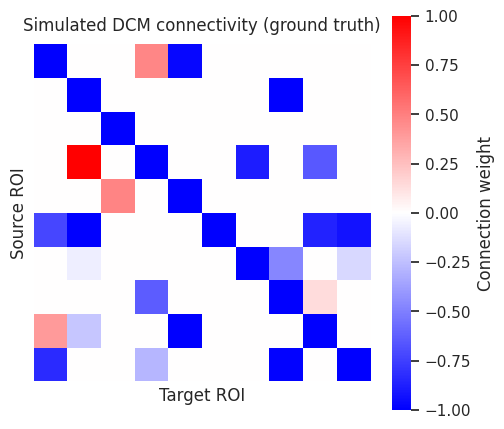

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Parámetros ---
D = 10
A_dcm = create_asym_matrix(D=D, sparsity=0.7, seed=42)

# --- Estilo ---
sns.set_theme(style="white", font_scale=1.0)

# --- Figura ---
fig, ax = plt.subplots(figsize=(5.2, 5))

sns.heatmap(
    A_dcm,
    ax=ax,
    cmap="bwr",
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    annot=False,
    cbar_kws={
        "label": "Connection weight",
        "shrink": 0.85
    }
)

# --- Etiquetas mínimas ---
ax.set_title("Simulated DCM connectivity (ground truth)", pad=10)
ax.set_xlabel("Target ROI")
ax.set_ylabel("Source ROI")

# --- Eliminar ticks y bordes ---
ax.set_xticks([])
ax.set_yticks([])
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

In [16]:
from dcm_exp1 import get_network_events, get_dcm_instance
from utils import save_nii
from sklearn.preprocessing import StandardScaler
import os
import numpy as np

def generate_dcm_from_A(timeline,
                        A,
                        data_dirname="data_dcm_from_customA",
                        N_subjects=1,
                        N_instances=1,
                        nblocks=5,
                        duration_range=(1,3),
                        SNRs=[0],
                        noise_type="invivo"):
    """
    Genera dataset DCM (A.nii, U.nii, X_snr*.nii) usando una matriz A dada.
    """
    N_pts = len(timeline)
    N_nds = A.shape[0]

    if not os.path.exists(data_dirname):
        os.mkdir(data_dirname)

    dirdataset = os.path.join(data_dirname, f"nds{N_nds}")
    if not os.path.exists(dirdataset):
        os.mkdir(dirdataset)

    for s in range(N_subjects):
        dirsubject = os.path.join(dirdataset, f"sub{s+1}")
        if not os.path.exists(dirsubject):
            os.mkdir(dirsubject)

        Xs = np.zeros((N_pts, N_nds, N_instances))
        Xs_bold = np.zeros((N_pts, N_nds, N_instances))

        # pseudoeventos
        U = get_network_events(timeline, N_nds, nblocks, duration_range)

        for i in range(N_instances):
            X_bold_i, X_i = get_dcm_instance(timeline, U, A)
            # estandarizar cada instancia
            Xs_bold[:, :, i] = StandardScaler().fit_transform(X_bold_i)
            Xs[:, :, i] = StandardScaler().fit_transform(X_i)

        # guardar A y U
        save_nii(os.path.join(dirsubject, "A.nii"), A, verbose=True)
        save_nii(os.path.join(dirsubject, "U.nii"), U, verbose=True)

        # añadir ruido (aquí uso gaussiano para no depender del .mat)
        from dcm_exp1 import add_noise_dcm_gsn  # ya lo tienes ahí
        for snr in SNRs:
            Xs_bold_noisy = add_noise_dcm_gsn(Xs_bold, snr)
            save_nii(os.path.join(dirsubject, f"X_snr{snr}.nii"),
                     Xs_bold_noisy, verbose=True)

In [17]:
# timeline y parámetros de simulación
N_pts = 3000
TR = 1.0
timeline = TR * np.arange(0, N_pts)

data_dirname = "/content/data_dcm_from_customA"

generate_dcm_from_A(
    timeline,
    A=A_dcm,
    data_dirname=data_dirname,
    N_subjects=1,
    N_instances=1,
    nblocks=5,
    duration_range=(1,3),
    SNRs=[0, 0.5],   # sin ruido y con ruido
    noise_type="invivo"
)

Saving the file /content/data_dcm_from_customA/nds10/sub1/A.nii
Saving the file /content/data_dcm_from_customA/nds10/sub1/U.nii
Saving the file /content/data_dcm_from_customA/nds10/sub1/X_snr0.nii
Saving the file /content/data_dcm_from_customA/nds10/sub1/X_snr0.5.nii


Leyendo datos desde: /content/data_dcm_from_customA/nds10/sub1
A_true es A_dcm: True
Shapes -> A_true: (10, 10) | X: (3000, 10)
B0 shape: (10, 10)
Número de lags estimados: 1
MSE(B0 vs A_true)   = 0.055161 | Corr = 0.751
MSE(Beff vs A_true) = 0.102002 | Corr = 0.649


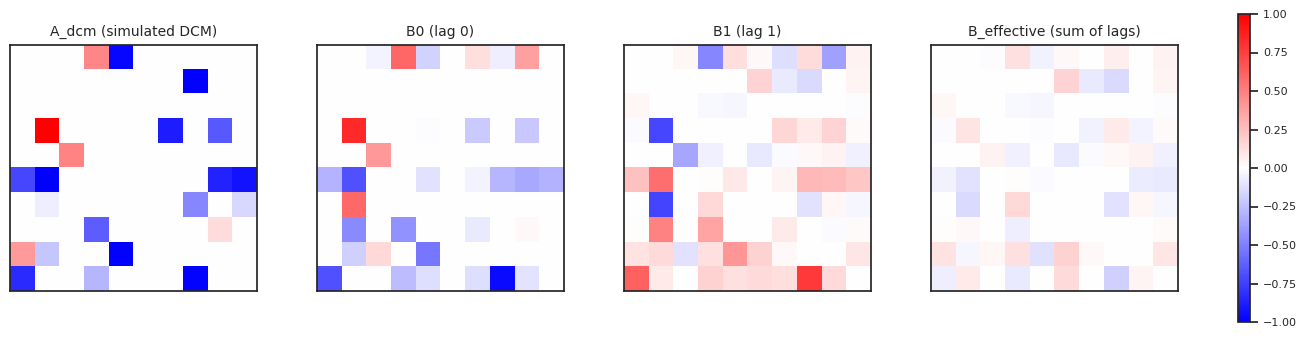

In [18]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from lingam import VARLiNGAM
from matplotlib.gridspec import GridSpec

# ==========================================================
# 1) CONFIG: usar la misma carpeta donde generaste los datos
# ==========================================================
base_dir = "/content/data_dcm_from_customA"   # misma que en generate_dcm_from_A
D = A_dcm.shape[0]                            # número de nodos
sub = "sub1"
snr_tag = "0"                                 # "0" o "0.5"

datadir = os.path.join(base_dir, f"nds{D}", sub)
print("Leyendo datos desde:", datadir)

# ==========================================================
# 2) GROUND TRUTH: USAR DIRECTAMENTE A_dcm
# ==========================================================
A_true = A_dcm.copy()
print("A_true es A_dcm:", np.allclose(A_true, A_dcm))

# ==========================================================
# 3) CARGAR BOLD SIMULADA
# ==========================================================
X_path = os.path.join(datadir, f"X_snr{snr_tag}.nii")
X_full = np.asanyarray(nib.load(X_path).get_fdata()).squeeze()   # (T,D) o (T,D,N_inst)

# Si tiene varias instancias, promediamos
if X_full.ndim == 3:
    X = X_full.mean(axis=2)
else:
    X = X_full

print("Shapes -> A_true:", A_true.shape, "| X:", X.shape)

# ==========================================================
# 4) ESTANDARIZAR Y AJUSTAR VAR-LiNGAM
# ==========================================================
Xz = StandardScaler(with_mean=True, with_std=True).fit_transform(X)

model = VARLiNGAM(lags=1, criterion=None, prune=True, random_state=42)
model.fit(Xz)

B_list = model.adjacency_matrices_    # [B0, B1, ..., Bp]
print("B0 shape:", B_list[0].shape)
print("Número de lags estimados:", len(B_list) - 1)

B_effective = np.sum(B_list, axis=0)

# ==========================================================
# 5) MÉTRICAS: MSE y correlación OFF-DIAGONAL
# ==========================================================
def vec_offdiag(M):
    d = M.shape[0]
    mask = ~np.eye(d, dtype=bool)
    return M[mask].ravel()

def safe_corr(a, b):
    if np.std(a) == 0 or np.std(b) == 0:
        return np.nan
    return np.corrcoef(a, b)[0, 1]

y_true = vec_offdiag(A_true)
y_b0   = vec_offdiag(B_list[0])
y_be   = vec_offdiag(B_effective)

mse_b0  = np.mean((y_true - y_b0)**2)
mse_be  = np.mean((y_true - y_be)**2)
corr_b0 = safe_corr(y_true, y_b0)
corr_be = safe_corr(y_true, y_be)

print(f"MSE(B0 vs A_true)   = {mse_b0:.6f} | Corr = {corr_b0:.3f}")
print(f"MSE(Beff vs A_true) = {mse_be:.6f} | Corr = {corr_be:.3f}")

# ==========================================================
# 6) PLOT: A_dcm, B0, (B1 si existe) y B_effective
# ==========================================================
mats_to_plot = []

# A_dcm sin diagonal
A_dcm_nodiag = A_dcm.copy()
np.fill_diagonal(A_dcm_nodiag, 0.0)
mats_to_plot.append(("A_dcm (simulated DCM)", A_dcm_nodiag))

# B0 (lag instantáneo)
B0_nodiag = B_list[0].copy()
np.fill_diagonal(B0_nodiag, 0.0)
mats_to_plot.append(("B0 (lag 0)", B0_nodiag))

# B1 (lag 1) si existe
if len(B_list) > 1:
    B1_nodiag = B_list[1].copy()
    np.fill_diagonal(B1_nodiag, 0.0)
    mats_to_plot.append(("B1 (lag 1)", B1_nodiag))

# B_effective (suma de todos los lags)
Beff_nodiag = B_effective.copy()
np.fill_diagonal(Beff_nodiag, 0.0)
mats_to_plot.append(("B_effective (sum of lags)", Beff_nodiag))

# ----- Figura bonita en una fila, misma escala -----
n_mats = len(mats_to_plot)
global_max_abs = max(np.max(np.abs(M)) for _, M in mats_to_plot)

fig = plt.figure(figsize=(4 * n_mats, 4))
gs = GridSpec(1, n_mats + 1, width_ratios=[1]*n_mats + [0.05], wspace=0.3)

axes = []
images = []

for idx, (title, M) in enumerate(mats_to_plot):
    ax = fig.add_subplot(gs[0, idx])
    im = ax.imshow(M, cmap="bwr", vmin=-global_max_abs, vmax=global_max_abs)
    ax.set_title(title, fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    axes.append(ax)
    images.append(im)

# Colorbar común
cax = fig.add_subplot(gs[0, -1])
cbar = fig.colorbar(images[-1], cax=cax)
cbar.ax.tick_params(labelsize=8)

plt.show()

In [19]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# Re-define necessary variables from previous cells
base_dir = "/content/data_dcm_from_customA"
D = A_dcm.shape[0] # Assuming A_dcm is still in scope, or re-define D=10
sub = "sub1"
snr_tag = "0"

# Re-load timeline
N_pts = 3000
TR = 1.0
timeline = TR * np.arange(0, N_pts)

datadir = os.path.join(base_dir, f"nds{D}", sub)
X_path = os.path.join(datadir, f"X_snr{snr_tag}.nii")

# Load X_full
X_full = np.asanyarray(nib.load(X_path).get_fdata())

print(f"Shape of X_full: {X_full.shape}")

# Plotting the time series for each ROI in separate subplots
# fig, axes = plt.subplots(nrows=D, ncols=1, figsize=(12, 2 * D), sharex=True)

# for i in range(D):
#     axes[i].plot(timeline[:300], X_full[:, i, 0][:300])  # Plot for the i-th ROI, first signal instance
#     axes[i].set_title(f"ROI {i+1} BOLD Signal (SNR={snr_tag})")
#     axes[i].set_ylabel("Amplitude")
#     axes[i].grid(True)

# axes[-1].set_xlabel("Time (s)") # Set x-label only for the bottom subplot
# plt.tight_layout()
# plt.show()

Shape of X_full: (3000, 10, 1)


# DCM con lag

In [20]:
import sys
sys.path.insert(0, "/content/drive/MyDrive/Balloon/scripts")

import dcm_exp1
import importlib
importlib.reload(dcm_exp1)

from dcm_exp1 import get_dcm_instance_svar1, get_network_events

## Intento 4

In [21]:
import numpy as np

# --- Parámetros de prueba ---
N_pts = 3000
TR = 1.0
timeline = TR * np.arange(N_pts)

# A_custom: usa aquí la matriz que tú quieras como ground truth
# por ejemplo, si ya tienes A_dcm definida:
A_custom = A_dcm.copy()
N_nds = A_custom.shape[0]

# 1) Generar pseudoeventos U
U = get_network_events(timeline, N_nds, nblocks=5, duration_range=(1,3))

# 2) Simular con SVAR(1)
X_bold, X_neur, C_inst, B_lag = get_dcm_instance_svar1(
    timeline,
    U,
    A_custom=A_custom,
    p_inst=0.5,   # 50% de conexiones instantáneas, 50% con lag
    seed=42
)

print("X_bold shape:", X_bold.shape)
print("X_neur shape:", X_neur.shape)
print("C_inst shape:", C_inst.shape)
print("B_lag shape:", B_lag.shape)

X_bold shape: (3000, 10)
X_neur shape: (3000, 10)
C_inst shape: (10, 10)
B_lag shape: (10, 10)


In [22]:
import os
import numpy as np

# Define the directory in Google Drive
drive_balloon_dir = "/content/drive/MyDrive/Balloon"

# Ensure the directory exists
if not os.path.exists(drive_balloon_dir):
    print(f"Warning: Directory {drive_balloon_dir} does not exist. Please ensure Google Drive is mounted correctly.")
    os.makedirs(drive_balloon_dir, exist_ok=True)

# List of variables to save and their filenames
variables_to_save = {
    "X_bold": X_bold,
    "X_neur": X_neur,
    "C_inst": C_inst,
    "B_lag": B_lag,
    "A_custom": A_custom
}

print("Saving variables to Google Drive:")
for name, var_data in variables_to_save.items():
    filepath = os.path.join(drive_balloon_dir, f"{name}.npy")
    try:
        np.save(filepath, var_data)
        print(f"  - Successfully saved {name} (shape: {var_data.shape}) to {filepath}")
    except Exception as e:
        print(f"  - Error saving {name} to Google Drive: {e}")


Saving variables to Google Drive:
  - Successfully saved X_bold (shape: (3000, 10)) to /content/drive/MyDrive/Balloon/X_bold.npy
  - Successfully saved X_neur (shape: (3000, 10)) to /content/drive/MyDrive/Balloon/X_neur.npy
  - Successfully saved C_inst (shape: (10, 10)) to /content/drive/MyDrive/Balloon/C_inst.npy
  - Successfully saved B_lag (shape: (10, 10)) to /content/drive/MyDrive/Balloon/B_lag.npy
  - Successfully saved A_custom (shape: (10, 10)) to /content/drive/MyDrive/Balloon/A_custom.npy


In [23]:
from lingam import VARLiNGAM
from sklearn.preprocessing import StandardScaler

Xz = StandardScaler().fit_transform(X_bold)  # BOLD simulada

model = VARLiNGAM(lags=1, prune=True, random_state=7)
model.fit(Xz)

B_list = model.adjacency_matrices_
B0_est = B_list[0]
B1_est = B_list[1]
B_eff_est = B0_est + B1_est

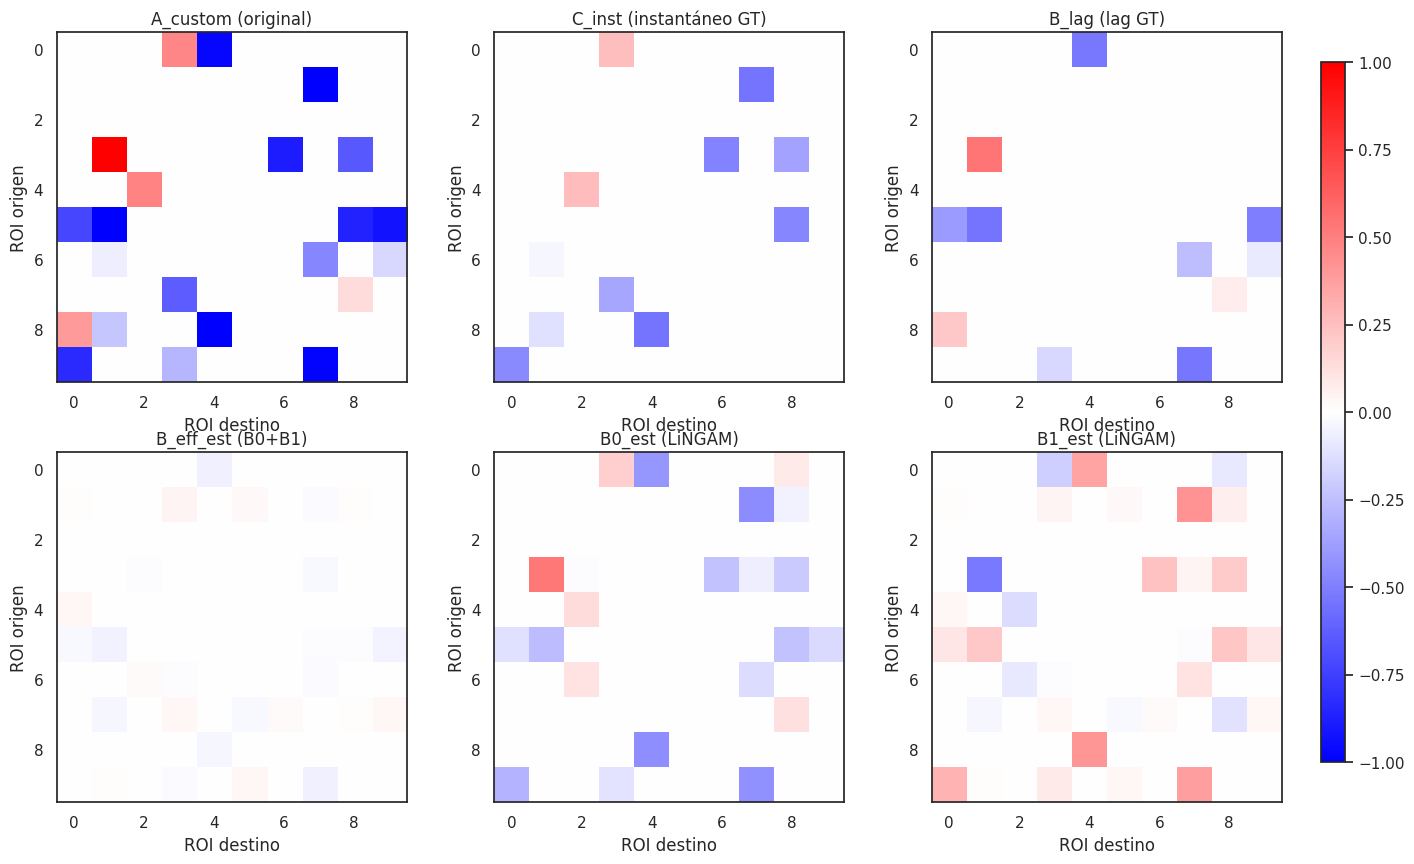

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def zero_diag(M):
    M = M.copy()
    np.fill_diagonal(M, 0.0)
    return M

mats = [
    ("A_custom (original)",        zero_diag(A_custom)),
    ("C_inst (instantáneo GT)",    zero_diag(C_inst)),
    ("B_lag (lag GT)",             zero_diag(B_lag)),
    ("B_eff_est (B0+B1)",          zero_diag(B_eff_est)),
    ("B0_est (LiNGAM)",            zero_diag(B0_est)),
    ("B1_est (LiNGAM)",            zero_diag(B1_est)),
]

# --- rango común de la escala ---
v = max(np.max(np.abs(M)) for _, M in mats)
v = max(v, 1e-6)

# --- FIGURA 2x3 ---
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# importante: NO llamar fig.colorbar dentro del loop
im = None
for ax, (title, M) in zip(axes.ravel(), mats):
    im = ax.imshow(M, cmap="bwr", vmin=-v, vmax=v)
    ax.set_title(title)
    ax.set_xlabel("ROI destino")
    ax.set_ylabel("ROI origen")

# --- única colorbar, afuera a la derecha ---
# borrar cualquier llamada anterior a fig.colorbar que tuvieras
fig.subplots_adjust(right=0.90)  # deja espacio a la derecha
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)

plt.show()

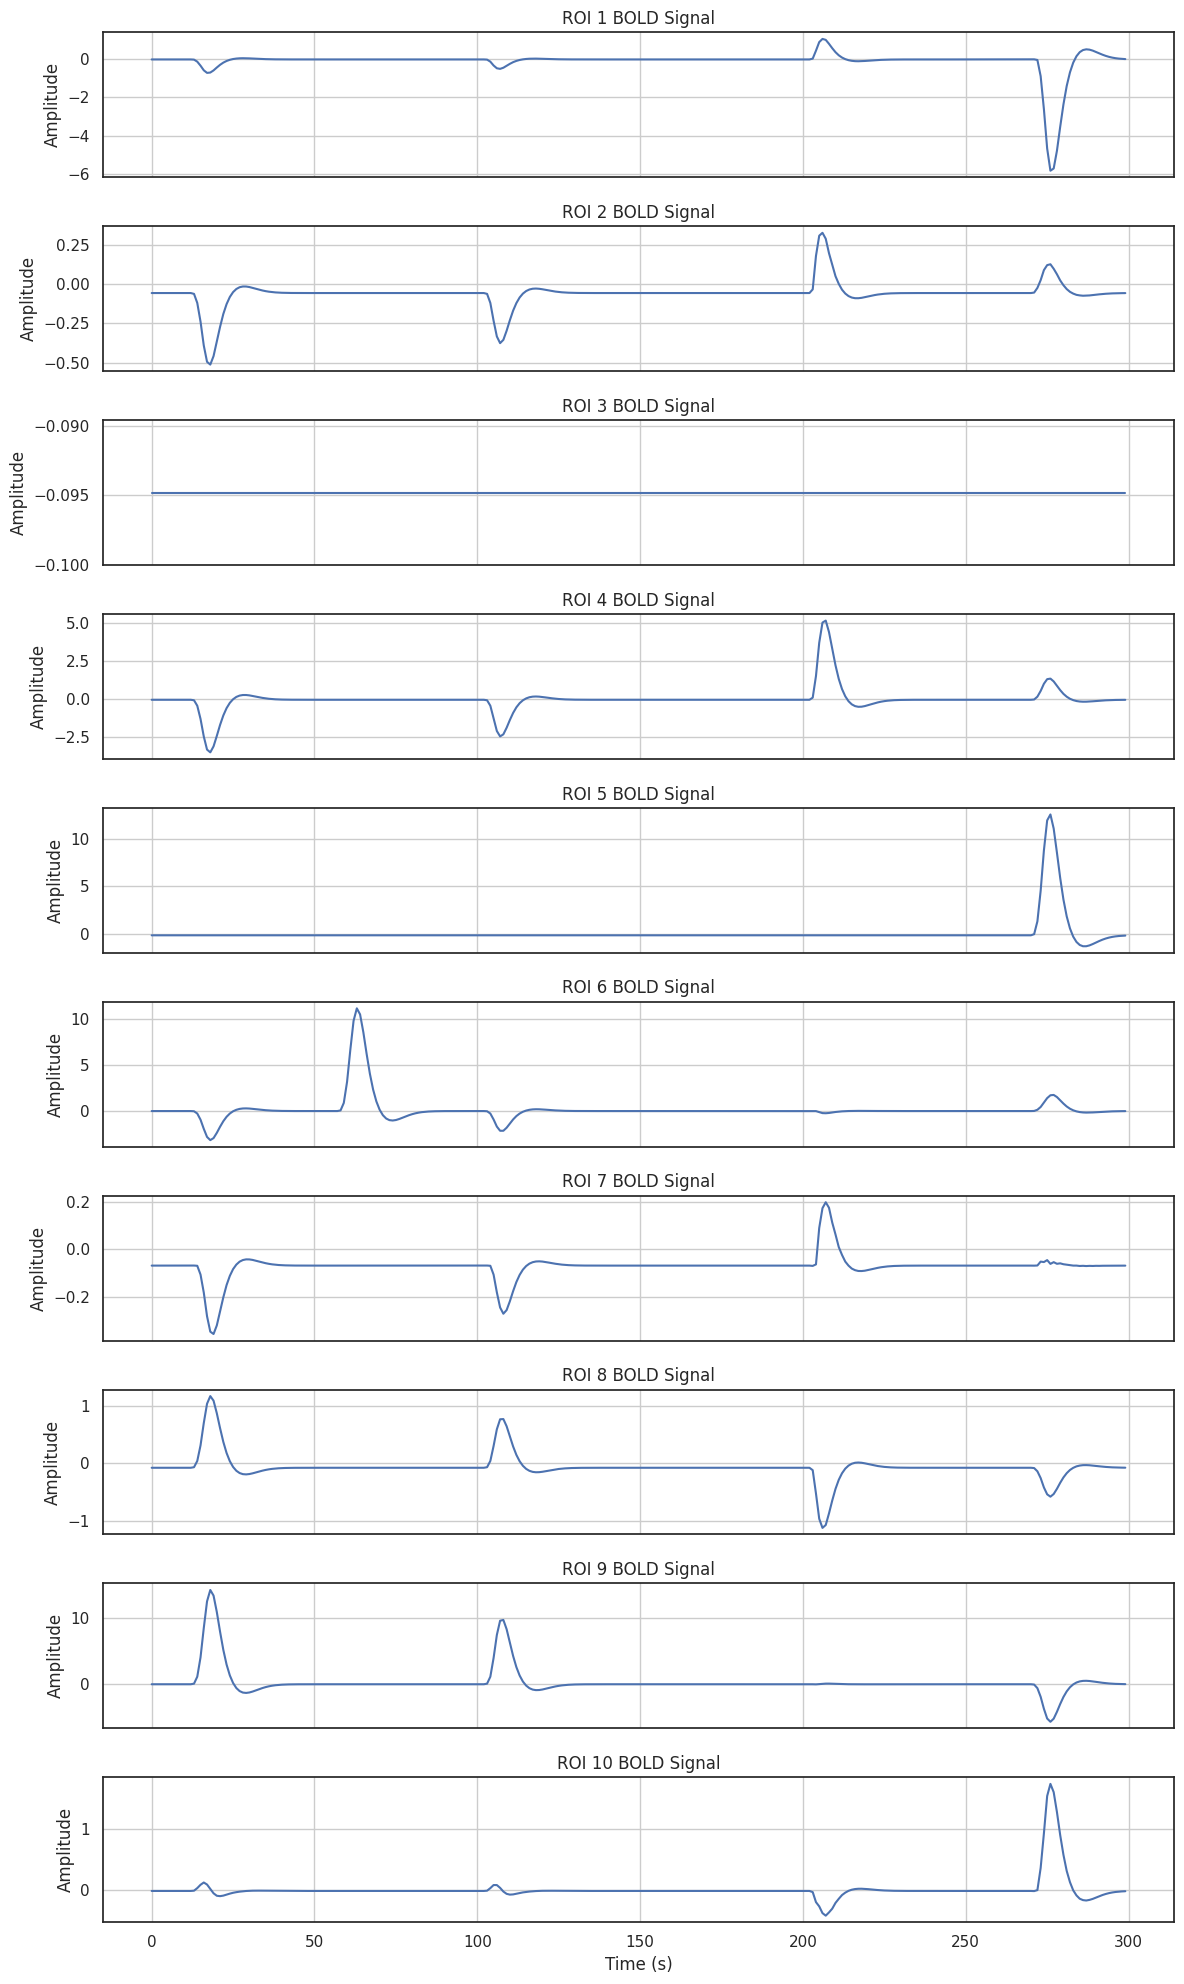

In [25]:
import matplotlib.pyplot as plt

# Assuming X_bold and timeline are already defined from previous cells
# N_nds is also defined as A_custom.shape[0]

# Check if X_bold is 2D (T, D) or 3D (T, D, N_instances)
# If it's 3D, we'll just plot the first instance or average if that's preferred.
# For now, assuming it's (T, D) based on previous usage (X_bold from get_dcm_instance_svar1 is (T,D))

D = X_bold.shape[1] # Number of ROIs

fig, axes = plt.subplots(nrows=D, ncols=1, figsize=(12, 2 * D), sharex=True)

for i in range(D):
    axes[i].plot(timeline[:300], X_bold[:300, i])
    axes[i].set_title(f"ROI {i+1} BOLD Signal")
    axes[i].set_ylabel("Amplitude")
    axes[i].grid(True)

axes[-1].set_xlabel("Time (s)") # Set x-label only for the bottom subplot
plt.tight_layout()
plt.show()

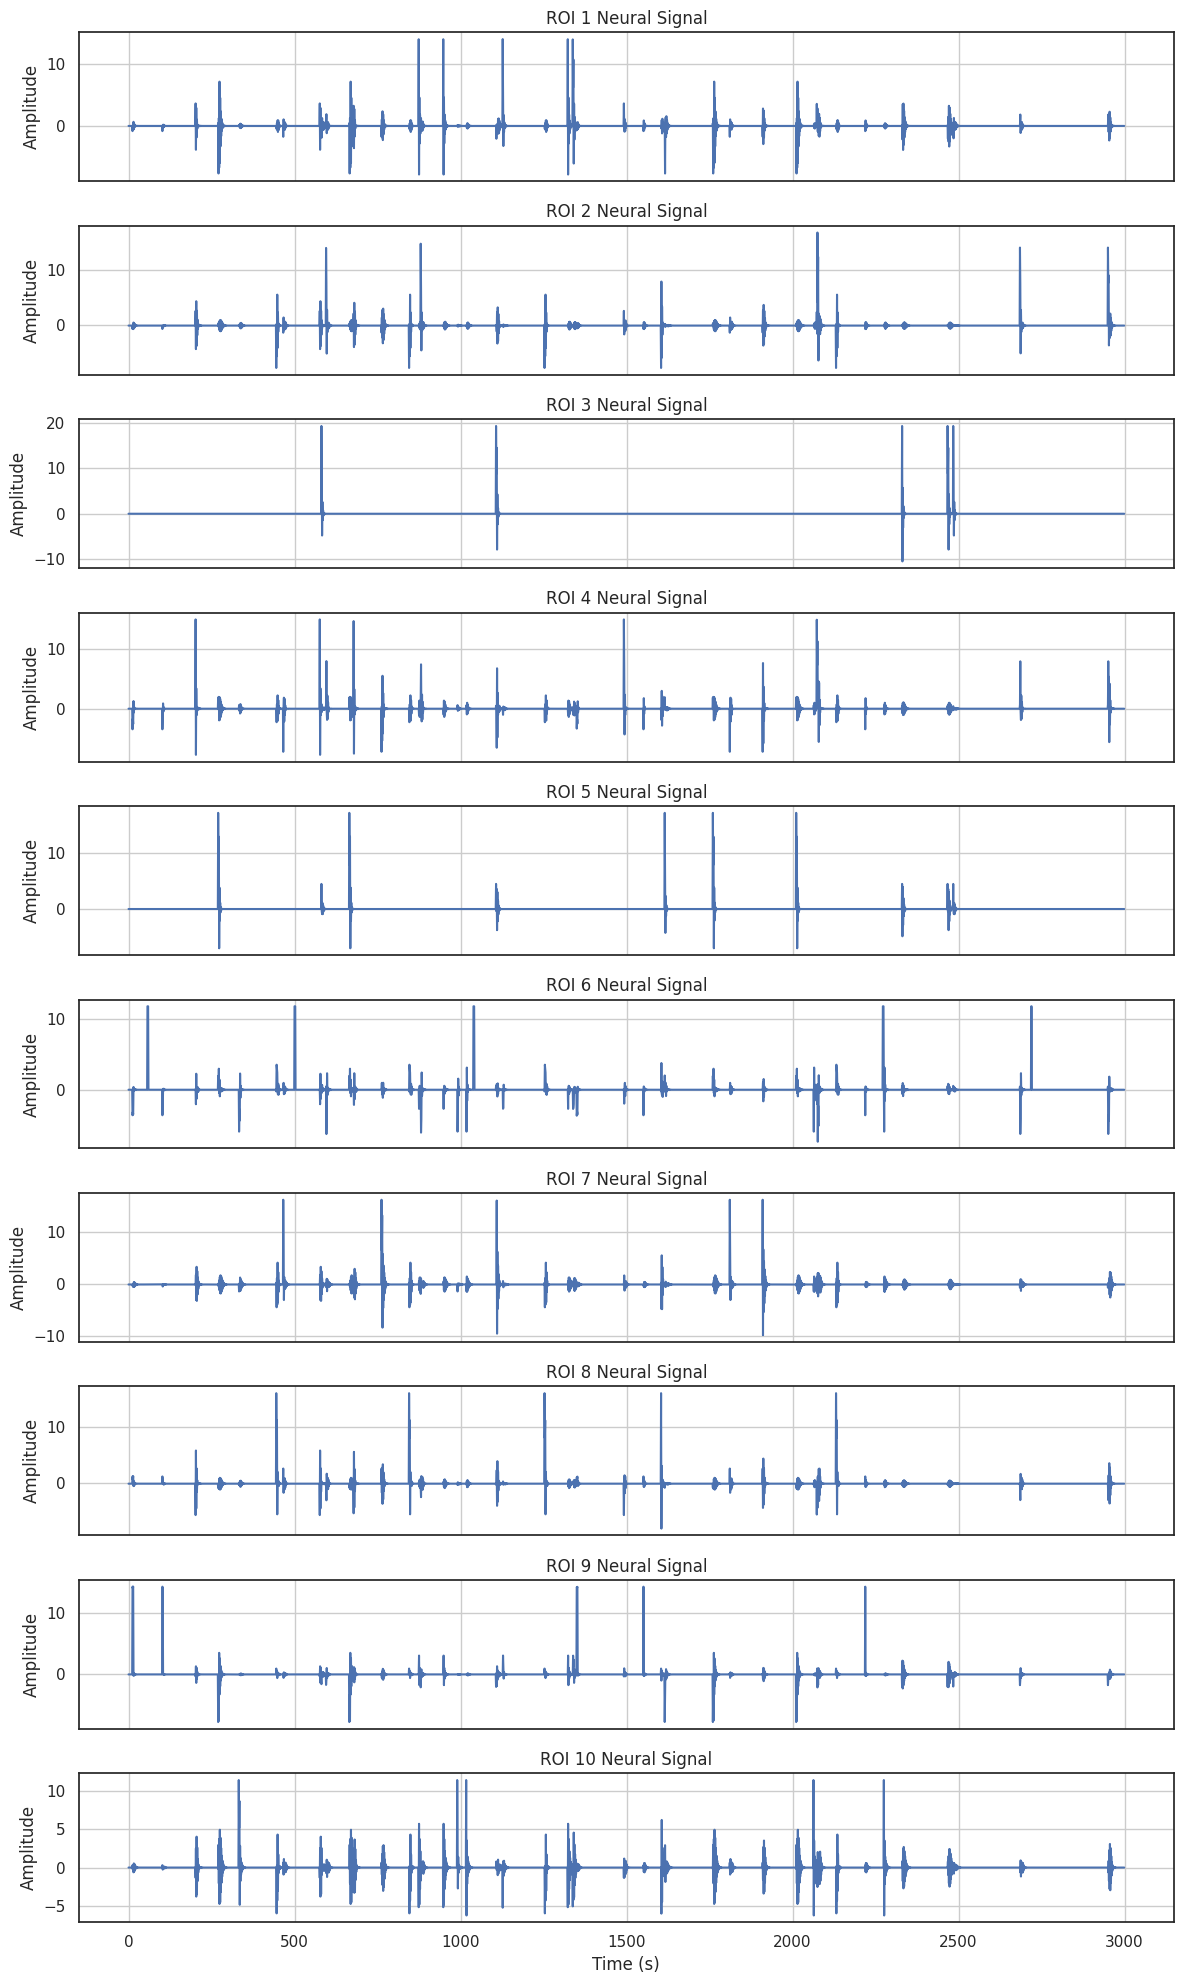

In [27]:
import matplotlib.pyplot as plt

# Assuming X_neur and timeline are already defined from previous cells

D = X_neur.shape[1] # Number of ROIs

fig, axes = plt.subplots(nrows=D, ncols=1, figsize=(12, 2 * D), sharex=True)

for i in range(D):
    axes[i].plot(timeline[:3000], X_neur[:3000, i])
    axes[i].set_title(f"ROI {i+1} Neural Signal")
    axes[i].set_ylabel("Amplitude")
    axes[i].grid(True)

axes[-1].set_xlabel("Time (s)") # Set x-label only for the bottom subplot
plt.tight_layout()
plt.show()

## Intento 5

In [ ]:
from lingam import VARLiNGAM
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Standardize X_neur
Xz_neur = StandardScaler().fit_transform(X_neur)

# Initialize and fit VAR-LiNGAM model
model_neur = VARLiNGAM(lags=1, prune=True, random_state=42) # Using random_state for reproducibility
model_neur.fit(Xz_neur)

# Extract adjacency matrices
B_list_neur = model_neur.adjacency_matrices_
B0_est_neur = B_list_neur[0]
B1_est_neur = B_list_neur[1]
B_eff_est_neur = B0_est_neur + B1_est_neur

print(f"B0_est_neur shape: {B0_est_neur.shape}")
print(f"B1_est_neur shape: {B1_est_neur.shape}")
print(f"B_eff_est_neur shape: {B_eff_est_neur.shape}")

# --- Plotting the results ---
def zero_diag(M):
    M = M.copy()
    np.fill_diagonal(M, 0.0)
    return M

# Separate ground truth and estimated matrices
ground_truth_mats = [
    ("A_custom (Ground Truth)", zero_diag(A_custom)),
    ("C_inst (True Instantaneous)", zero_diag(C_inst)),
    ("B_lag (True Lagged)", zero_diag(B_lag)),
]

estimated_mats = [
    ("B_eff_est (B0+B1) from X_neur", zero_diag(B_eff_est_neur)),
    ("B0_est (LiNGAM) from X_neur", zero_diag(B0_est_neur)),
    ("B1_est (LiNGAM) from X_neur", zero_diag(B1_est_neur)),
]

all_mats_for_scale = [
M for _, M in ground_truth_mats + estimated_mats
]

# Determine common color scale range for all matrices
global_max_abs_neur = max(np.max(np.abs(M)) for M in all_mats_for_scale)
if global_max_abs_neur == 0: global_max_abs_neur = 1e-6 # Avoid division by zero if all values are zero

# Use GridSpec for a more controlled layout including the colorbar
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 3 + 1, width_ratios=[1, 1, 1, 0.05], wspace=0.3, hspace=0.4) # 3 columns for plots + 1 for colorbar

axes = []
im = None # Initialize im for colorbar reference

# Plot ground truth matrices on the first row
for i, (title, M) in enumerate(ground_truth_mats):
    ax = fig.add_subplot(gs[0, i])
    im = ax.imshow(M, cmap="bwr", vmin=-global_max_abs_neur, vmax=global_max_abs_neur)
    ax.set_title(title, fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("Target ROI")
    ax.set_ylabel("Source ROI")
    axes.append(ax)

# Plot estimated matrices on the second row
for i, (title, M) in enumerate(estimated_mats):
    ax = fig.add_subplot(gs[1, i])
    im = ax.imshow(M, cmap="bwr", vmin=-global_max_abs_neur, vmax=global_max_abs_neur)
    ax.set_title(title, fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("Target ROI")
    ax.set_ylabel("Source ROI")
    axes.append(ax)

# Common colorbar using the last column of GridSpec
cbar_ax = fig.add_subplot(gs[:, -1]) # Spans both rows, last column
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=8)

plt.suptitle('VAR-LiNGAM Estimated Adjacency Matrices from X_neur', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust rect to make space for suptitle
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# The previous cell (KM0NV-uPN4bR) already computed Xz_neur, B0_est_neur, B1_est_neur, B_eff_est_neur.
# This cell assumes those variables (A_custom, C_inst, B_lag, B0_est_neur, B1_est_neur, B_eff_est_neur) are available in the kernel state.

# --- Plotting function ---
def zero_diag(M):
    M = M.copy()
    np.fill_diagonal(M, 0.0)
    return M

# We only want to plot the ground truth matrices
mats_to_plot = [
    ("A_custom (Ground Truth)", zero_diag(A_custom)),
    ("C_inst (True Instantaneous)", zero_diag(C_inst)),
    ("B_lag (True Lagged)", zero_diag(B_lag)),
]

# Determine common color scale range for all matrices (including estimated ones for consistent scaling)
# This uses estimated matrices for the scale reference, but only plots ground truth.
all_mats_for_scale = [
    M for _, M in mats_to_plot + [
        ("B_eff_est (B0+B1) from X_neur", zero_diag(B_eff_est_neur)),
        ("B0_est (LiNGAM) from X_neur", zero_diag(B0_est_neur)),
        ("B1_est (LiNGAM) from X_neur", zero_diag(B1_est_neur)),
    ]
]
global_max_abs_neur = max(np.max(np.abs(M)) for M in all_mats_for_scale)
if global_max_abs_neur == 0: global_max_abs_neur = 1e-6 # Avoid division by zero if all values are zero


# Use GridSpec for a more controlled layout including the colorbar
n_mats = len(mats_to_plot) # This will be 3
fig = plt.figure(figsize=(4 * n_mats, 5)) # Adjust figsize for 1 row, 3 plots
gs = GridSpec(1, n_mats + 1, width_ratios=[1]*n_mats + [0.05], wspace=0.3)

axes = []
im = None # Initialize im for colorbar reference

# Plot only the selected ground truth matrices
for i, (title, M) in enumerate(mats_to_plot):
    ax = fig.add_subplot(gs[0, i]) # Plot on the first (and only) row
    im = ax.imshow(M, cmap="bwr", vmin=-global_max_abs_neur, vmax=global_max_abs_neur)
    ax.set_title(title, fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("Target ROI")
    ax.set_ylabel("Source ROI")
    axes.append(ax)

# Common colorbar using the last column of GridSpec
cbar_ax = fig.add_subplot(gs[0, -1]) # Spans only the single row, last column
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=8)

plt.suptitle('Ground Truth Adjacency Matrices', fontsize=14) # Adjusted title
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust rect to make space for suptitle
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Assuming X_bold and timeline are already defined from previous cells
# D is also defined as A_custom.shape[0]

D = X_bold.shape[1] # Number of ROIs

fig, axes = plt.subplots(nrows=D, ncols=1, figsize=(12, 2 * D), sharex=True)

for i in range(D):
    axes[i].plot(timeline[:1000], X_bold[:1000, i]) # Plotting first 300 points for clarity
    axes[i].set_title(f"ROI {i+1} BOLD Signal")
    axes[i].set_ylabel("Amplitude")
    axes[i].grid(True)

axes[-1].set_xlabel("Time (s)") # Set x-label only for the bottom subplot
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import os

base_path = "/content/drive/MyDrive/Balloon"
os.makedirs(base_path, exist_ok=True)

np.save(f"{base_path}/bold_dcm.npy", X_bold)
np.save(f"{base_path}/neur_dcm.npy", X_neur)

print("Guardado bold_dcm.npy y neur_dcm.npy")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="white")

# --- Matrices ---
A_true = A_dcm              # ground truth
A_est  = B_effective        # conectividad factual estimada

D = A_true.shape[0]

# --- Máscara para ocultar diagonal ---
mask = np.eye(D, dtype=bool)

# --- Escala común ---
vmax = max(np.abs(A_true).max(), np.abs(A_est).max())

# --- Figura ---
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

sns.heatmap(
    A_true,
    ax=axes[0],
    cmap="bwr",
    center=0,
    vmin=-vmax,
    vmax=vmax,
    square=True,
    mask=mask,
    cbar=False
)
axes[0].set_title("Ground truth")
axes[0].set_xticks([])
axes[0].set_yticks([])

sns.heatmap(
    A_est,
    ax=axes[1],
    cmap="bwr",
    center=0,
    vmin=-vmax,
    vmax=vmax,
    square=True,
    mask=mask,
    cbar=True,
    cbar_kws={"shrink": 0.8}
)
axes[1].set_title("Estimated connectivity (factual)")
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.tight_layout()
plt.show()